# Detectando Sarcasmos em passagens de textos

In [1]:
# Versão da Linguagem Python utilizada
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.2


## 1 - Definição do Problema

Este projeto tem o objetivo de identificar se uma passagem de texto é sarcasmo ou não. 

Estudos sobre a detecção de sarcasmo usam principalmente conjuntos de dados do Twitter coletados usando a supervisão baseada em hashtag, mas esses conjuntos de dados são muito ruidosos em termos de rótulos e idioma. Além disso, muitos tweets são respostas a outros tweets e a detecção de sarcasmo exige a disponibilidade de tweets contextuais.

Para superar as limitações relacionadas ao ruído nos conjuntos de dados do Twitter, um grupo de pesquisadores da Universidade de Princeton nos EUA, criou um conjunto de dados de notícias para a Detecção de Sarcasmo. Os dados foram coletados em dois sites de notícias:

O site <a href=https://www.theonion.com/>TheOnion</a> tem como objetivo produzir versões sarcásticas dos eventos atuais e foram coletadas todas as manchetes das categorias Notícias em Breve e Notícias em Fotos (que são sarcásticas). Coletaram ainda manchetes de notícias reais (e não sarcásticas) do <a href=https://www.huffpost.com/>HuffPost</a>.

Aqui o link do estudo: https://arxiv.org/pdf/1704.05579.pdf

Aqui o link do dataset: https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection

Este conjunto de dados tem as seguintes vantagens sobre os conjuntos de dados do Twitter:

- Como as manchetes das notícias são escritas por profissionais de maneira formal, não há erros ortográficos e uso informal. Isso reduz a escassez de dados pois teremos menos trabalho de limpeza.


- Além disso, como o único objetivo do TheOnion é publicar notícias sarcásticas, obtemos rótulos de alta qualidade com muito menos ruído em comparação com os conjuntos de dados do Twitter.


- Diferentemente dos tweets que são respostas a outros tweets, as manchetes obtidas são independentes. Isso nos ajuda a separar os verdadeiros elementos sarcásticos.

In [2]:
# Imports
import json
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
print("Versões de Pacotes")
%watermark --iversions

Versões de Pacotes
numpy            1.18.2
tensorflow       2.2.0-rc2
matplotlib       3.2.1
tensorflow.keras 2.3.0-tf
json             2.0.9



## 2 - Carga dos Dados

Cada registro tem 3 atributos
- is_sarcastic: 1 se o registro for sarcástico, caso contrário 0
- headline: a manchete da reportagem
- article_link: link para o artigo de notícias original. Útil na coleta de dados suplementares

In [4]:
# Carregando os dados
with open("data/Sarcasm_Headlines_Dataset.json") as file:
    dados = json.load(file)

In [5]:
len(dados)

26709

In [6]:
dados[0]

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
 'is_sarcastic': 0}

In [7]:
# Separando as variáveis
article_link = []
headline = []
sarcastic = []
for content in dados:
    article_link.append(content["article_link"])
    headline.append(content["headline"])
    sarcastic.append(content["is_sarcastic"])

## 3 - Pré-processamento

### 3.1 - Separação dos dados

In [8]:
# Separando os dados

qt_registros_treino = 15000

# Dados de entrada (X)
x_treino = headline[:qt_registros_treino]
x_teste = headline[qt_registros_treino:]

# Dados de saída (Y)
y_treino = sarcastic[:qt_registros_treino]
y_teste = sarcastic[qt_registros_treino:]

In [9]:
len(x_treino),len(x_teste)

(15000, 11709)

### 3.2 - Tokenização

In [10]:
# A função Tokenizer recebe 2 parâmetros:
### - num_words: número máximo de palavras a serem mantidas, com base na frequência das palavras. Somente as palavras com a frequência máxima serão mantidas.
### - oov_token: usado para substituir palavras fora do vocabulário durante chamadas text_to_sequence

vocabulario = 10000
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words = vocabulario, oov_token = oov_token)
tokenizer.fit_on_texts(x_treino)
x_treino = tokenizer.texts_to_sequences(x_treino) 

In [11]:
x_teste = tokenizer.texts_to_sequences(x_teste) 

### 3.3 Padding

In [12]:
# A função pad_sequences do Keras recebe os seguintes parâmetros:
### - sequences: Lista de listas, onde cada elemento é uma sequência.
### - maxlen: Int, comprimento máximo de todas as sequências.
### - padding: String, 'pre' ou 'post': inclui antes ou depois de cada sequência.
### - truncating: String, 'pre' ou 'post': remova valores de sequências maiores que maxlen, no início ou no final das sequências.

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

# Parâmetros
padding = 'post'
trunc = 'post'
max_length = 100

# Sequence Padding nos dados de treino
padded_x_treino = pad_sequences(x_treino, 
                                padding = padding, 
                                truncating = trunc, 
                                maxlen = max_length)

In [13]:
# Sequence Padding nos dados de teste
padded_x_teste = pad_sequences(x_teste, 
                               padding = padding, 
                               truncating = trunc, 
                               maxlen = max_length)

In [14]:
# Converte todas as estruturas para array NumPy

# Converte X
x_treino = np.array(padded_x_treino)
x_teste = np.array(padded_x_teste)

# Converte y
y_treino = np.array(y_treino)
y_teste = np.array(y_teste)

x_treino.shape, y_treino.shape, x_teste.shape, y_teste.shape

((15000, 100), (15000,), (11709, 100), (11709,))

## 4 - Rede Neural

In [15]:
# Dimensões embedding
embedding_dim = 16

# Cria a sequência de camadas
model = keras.Sequential()

# Camada de entrada
model.add(keras.layers.Embedding(vocabulario, embedding_dim, input_length = max_length))

# Camada Global de Pooling para reduzir a dimensionalidade da camada de entrada
model.add(keras.layers.GlobalAveragePooling1D())

# Camada oculta densa com ativação relu
model.add(keras.layers.Dense(24, activation = 'relu'))

# Camada de saída com ativação sigmoide para prever as probabilidades
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

# Compila o modelo com o otimizador, função de custo e métrica de avaliação
model.compile(optimizer = "adam", loss = keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Treinamento do modelo
modelo = model.fit(x_treino, 
                   y_treino, 
                   epochs = 10, 
                   validation_data = (x_teste, y_teste), 
                   verbose = 1)

Epoch 1/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6832 - accuracy: 0.5547 - val_loss: 0.6607 - val_accuracy: 0.5718
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.5392 - accuracy: 0.7679 - val_loss: 0.4394 - val_accuracy: 0.8142
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.3609 - accuracy: 0.8579 - val_loss: 0.3731 - val_accuracy: 0.8406
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2914 - accuracy: 0.8892 - val_loss: 0.3748 - val_accuracy: 0.8305
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2487 - accuracy: 0.9074 - val_loss: 0.3445 - val_accuracy: 0.8504
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2159 - accuracy: 0.9193 - val_loss: 0.3493 - val_accuracy: 0.8480
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1904 - accuracy: 0.9292 - val_loss: 0.3474 - val_accuracy: 0.8530
Epoch 

In [18]:
# Métricas disponíveis para o modelo
modelo.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

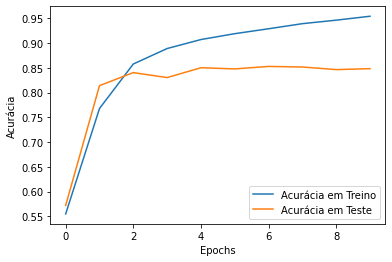

In [19]:
# Plot da Acurácia
plt.plot(modelo.history['accuracy'])
plt.plot(modelo.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(['Acurácia em Treino', 'Acurácia em Teste'])
plt.show()

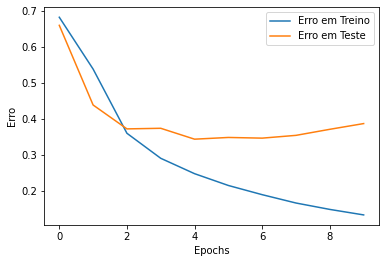

In [20]:
# Plot do Erro
plt.plot(modelo.history['loss'])
plt.plot(modelo.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Erro')
plt.legend(['Erro em Treino', 'Erro em Teste'])
plt.show()

## 5 - Detectando Sarcasmo

In [21]:
# Frases a serem verificadas
texto = ["I am actually not funny. I am just mean and people think I am joking",
         "I’d be fine if there were not so much blood in my alcohol system",
         "If you need so much space, there is always NASA",
         "game of thrones season finale showing this sunday night"]

In [22]:
# Aplicação das transformações de dados
sequences = tokenizer.texts_to_sequences(texto)
padded = pad_sequences(sequences, maxlen = max_length, padding = padding, truncating = trunc)

In [23]:
# Previsões
print(model.predict_classes(padded))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[0]
 [1]
 [0]
 [0]]


In [24]:
# Aplicando a predição para cada uma das frases
for i, frase in enumerate(texto):
    previsao = model.predict_classes(padded)
    if previsao[i] == 0:
        print('\nA Frase <', frase, '> não é sarcasmo!')
    else:
        print('\nA Frase <', frase, '> é sarcasmo!')


A Frase < I am actually not funny. I am just mean and people think I am joking > não é sarcasmo!

A Frase < I’d be fine if there were not so much blood in my alcohol system > é sarcasmo!

A Frase < If you need so much space, there is always NASA > não é sarcasmo!

A Frase < game of thrones season finale showing this sunday night > não é sarcasmo!
